**Space Weather Simulation Summer School 2023**

**Instructor: [Boris Kramer](http://kramer.ucsd.edu/)**

### Operator Inference for Space Weather Model Reduction


The goal of non-intrusive model reduction is to efficiently make physics-based predictions given high-fidelity simulation data. This tutorial explores learning a [operator inference](https://willcox-research-group.github.io/rom-operator-inference-Python3/source/index.html) reduced order model for the [conduction model](https://github.com/AetherModel/swsss2023/tree/main/day_06) taught earlier in the week.



**Relevant literature:**
1. Peherstorfer, B. and Willcox, K., *Data-driven operator inference for nonintrusive projection-based model reduction, Computer Methods in Applied Mechanics and Engineering*, Vol. 306, pp. 196-215, 2016. 

2. Issan, O. and Kramer, B., *Predicting solar wind streams from the inner-heliosphere to Earth via shifted operator inference*, Journal of Computational Physics, Vol. 473, pp. 111689, 2023. 

**Necessary data for this exercise (ask from the intructor before proceeding):**
1. *conduction_v6_data.npy* - simulation data of the temperature as a function of space and time. 
2. *conduction_v6_alt.npy* - the altitude, i.e. x, grid in km. 
3. *conduction_v6_time.npy* - the time, i.e. t, grid in hr. 
4. *conduction_v6_lower_bc.npy* - the lower boundary condition as a function of time. 

**Exercise Questions:**
1. It took 9.93 minutes to simulative the full order model data on MacBook Pro 2.3 GHz Quad-Core Intel Core i7 processor with 16 GB RAM. Assuming you are using a similar machine, how much faster was simulating the ROM? Discuss the motivation of using model reduction for space weather operational forecasting. 

2. There are a few hyperparameters that can improve the ROM accuracy: the regularization parameter $\lambda$ and the number of reduced basis $r$. Rigoursly test what happens when you increase the regularization parameter and/or the reduced basis dimension. Discuss your findings. 

**Full Order Model:** As taught by Prof. Aaron Ridley, the governing equations are 
$$
\frac{\partial}{\partial t} \underbrace{q(x, t)}_{\text{temperature}}= \underbrace{c \frac{\partial^2}{\partial x^2} q(x, t)}_{\text{conduction term}} + \underbrace{u(x, t)}_{\text{source term}}.
$$

Once discretized in space via finite differencing the semi-discrete form of the equations is given by 

$$
\frac{\mathrm{d}}{\mathrm{d}t} \mathbf{q}(t) = \mathbf{A} \mathbf{q}(t) + \mathbf{B} \mathbf{u}(t) 
$$

where $\mathbf{q}(t) \in \mathbb{R}^{n}, \mathbf{A} \in \mathbb{R}^{n\times n}, \mathbf{B} \in \mathbb{R}^{n \times m}, \mathbf{u}(t) \in \mathbb{R}^{m}$, $m=1$, $n=8001$

**Step 1: Import Python modules**

*Tip*: Install the latest version of *opinf* package using [pip](https://willcox-research-group.github.io/rom-operator-inference-Python3/source/opinf/installation.html). 

In [1]:
# import modules: numpy, scipy, opinf, matplotlib
import numpy as np 
import scipy.linalg as la
import scipy.sparse as sparse
import opinf
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

#### Step 2: Read in training data

The training data is provided as *conduction_v6_data.npy* file

In [2]:
# load simulation data using numpy 
data = np.load("conduction_v6_data.npy")
# use 100 snapshots for training and 43 for testing
Q_train = data[:, :100]
Q_test = data[:, 100:]
print("shape of the simulation data = ", np.shape(data))
print("shape of the training simulation data = ", np.shape(Q_train))
print("shape of the testing simulation data = ", np.shape(Q_test))

shape of the simulation data =  (8001, 143)
shape of the training simulation data =  (8001, 100)
shape of the testing simulation data =  (8001, 43)


In [3]:
# altitude in km
x = np.load("conduction_v6_alt.npy")/1000
dx = x[1] - x[0]
print(f"Spatial step size δx = {dx} km")

Spatial step size δx = 0.04999999999999716 km


In [4]:
# time in hr
time = np.load("conduction_v6_time.npy")[:-1]
dt = time[1] - time[0]
print(f"Temporal step size δt = {dt} hr")

Temporal step size δt = 1.0 hr


In [5]:
# inputs 
inputs = np.load("conduction_v6_lower_bc.npy")[:-1]

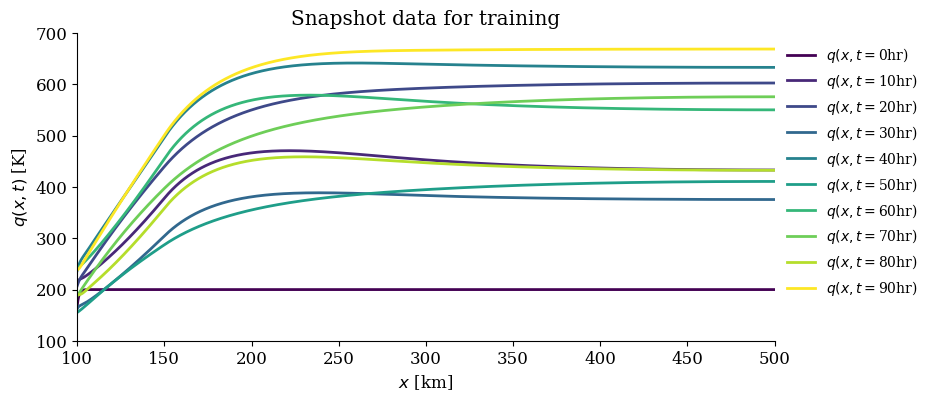

In [6]:
colors = plt.cm.viridis(np.linspace(0, 1, 10))
# plot the training data
fig, ax = plt.subplots(figsize=(9, 4))
# plot up to noon
for ii, tt in enumerate(np.arange(0, 100, 10)):
    ax.plot(x, Q_train[:, tt], linewidth=2, label="$q(x, t=$" + str(int(time[tt])) + "hr)", color=colors[ii])

# hide axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set axis limits 
ax.set_xlim(100, 500)
ax.set_ylim(100, 700)

# axis legends
ax.set_xlabel("$x$ [km]")
ax.set_ylabel("$q(x, t)$ [K]")

# add legend
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=10,  bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0)

# add title
_= ax.set_title("Snapshot data for training")

**Step 3: ROM construction \& learning**

Now that we have our training data $\mathbf{Q} \in \mathbb{R}^{n \times k}$, we can construct a basis matrix $\mathbf{V}_r \in \mathbb{R}^{n \times r}$, where $n=8001$ in our model and $r \ll n$. The basis matrix relates the high-dimensional state and low-dimensional state by $\mathbf{q}(t) \approx \mathbf{V}_{r}\widehat{\mathbf{q}}(t)$.

For operator inference, we use the proper orthogonal decomposition (POD) basis. The integer $r$, which defines the dimension of the reduced-order model to be constructed, is usually determined by how quickly the singular values of $\mathbf{Q}$ decay. In this example, we choose the minimal $r$ such that the residual energy is less than a given tolerance $\varepsilon$, i.e.,

$$
\frac{\sum_{j=r + 1}^{k}\sigma_{j}^{2}}{\sum_{j=1}^{k}\sigma_{j}^{2}} < \varepsilon, 
$$

PODBasis
Full-order dimension    n = 8001
Reduced-order dimension r = 23


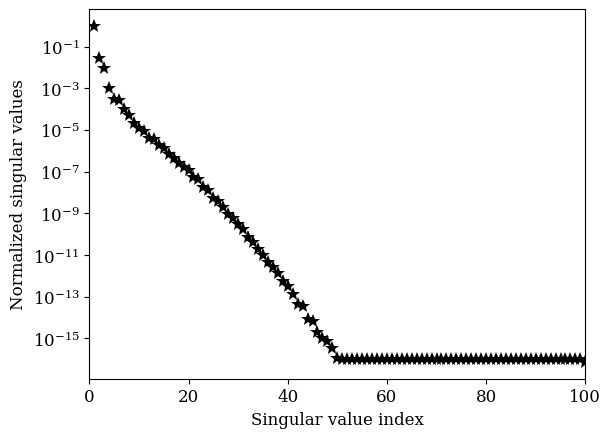

In [14]:
# Compute the POD basis, using the residual energy tolerance to select r.
basis = opinf.pre.PODBasis().fit(Q_train, residual_energy=1e-18)
print(basis)

# Check the decay of the singular values.
_ = basis.plot_svdval_decay()

In [8]:
# based on the cirteria above we set 
basis.r = 23

In [9]:
# approximate the dx/dt using forward euler finite differencing
training_data_ddt = (Q_train[:, 1:] - Q_train[:, :-1])/dt

In [24]:
# learn reduced model.
rom = opinf.ContinuousOpInfROM("AB")
rom.fit(basis=basis, states=Q_train[:, :-1], ddts=training_data_ddt, regularizer=1, inputs=inputs[1:100])

Reduced-order model structure: dq / dt = Aq(t) + Bu(t)
Full-order dimension    n = 8001
Input/control dimension m = 1
Reduced-order dimension r = 23

**Step 4: ROM evaluation**

We integrate the learned ROM using the implicit Euler method, using the reduced-order operators $\widehat{\mathbf{A}}$  and the initial condition $\widehat{\mathbf{q}}_{0} = \mathbf{V}^{\mathsf{T}}\mathbf{q}_{0}$.
The resulting low-dimensional state vectors are decoded back to the full-dimensional space via $\mathbf{q}(t) = \mathbf{V}_{r}\widehat{\mathbf{q}}(t)$.

In [25]:
# Express the initial condition in the coordinates of the basis.
q0_ = rom.encode(Q_train[:, 0])

# Solve the reduced-order model using BDF
Q_ROM = rom.predict(state0=q0_, t=time, decode=True, input_func=inputs)

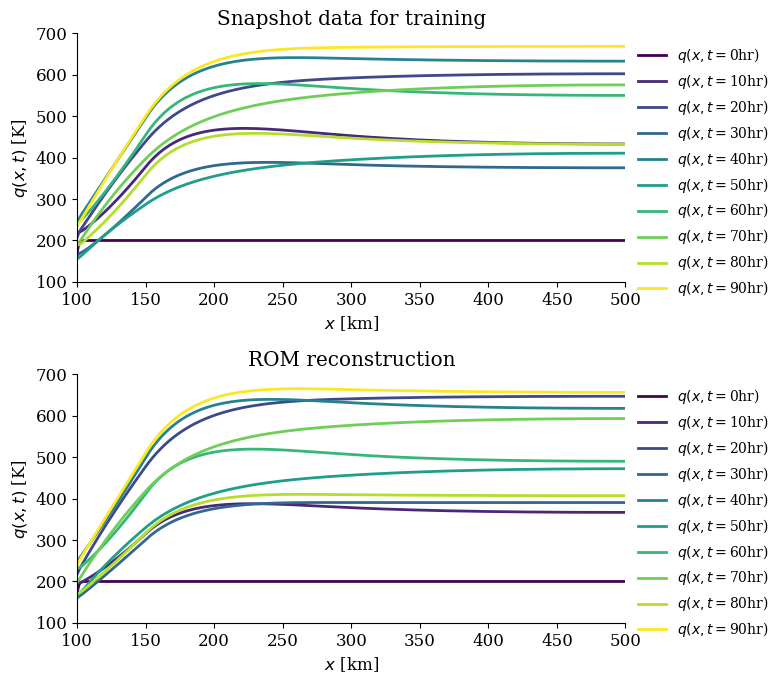

In [26]:
# plot the training data
fig, ax = plt.subplots(nrows=2, figsize=(8, 7))
# plot up to noon
for ii, tt in enumerate(np.arange(0, 100, 10)):
    ax[0].plot(x, Q_train[:, tt], linewidth=2, label="$q(x, t=$" + str(tt) + "hr)", color=colors[ii])
    ax[1].plot(x, Q_ROM[:, tt], linewidth=2, label="$q(x, t=$" + str(tt) + "hr)", color=colors[ii])
# hide axis
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

# set axis limits 
ax[0].set_xlim(100, 500)
ax[1].set_xlim(100, 500)
ax[0].set_ylim(100, 700)
ax[1].set_ylim(100, 700)

# axis legends
ax[0].set_xlabel("$x$ [km]")
ax[0].set_ylabel("$q(x, t)$ [K]")
ax[1].set_xlabel("$x$ [km]")
ax[1].set_ylabel("$q(x, t)$ [K]")

# add legend
legend = ax[0].legend(ncols=1, fancybox=False, shadow=False, fontsize=10,  bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0)
legend = ax[1].legend(ncols=1, fancybox=False, shadow=False, fontsize=10,  bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0)


# add title
_= ax[0].set_title("Snapshot data for training")
_= ax[1].set_title("ROM reconstruction")
plt.tight_layout()

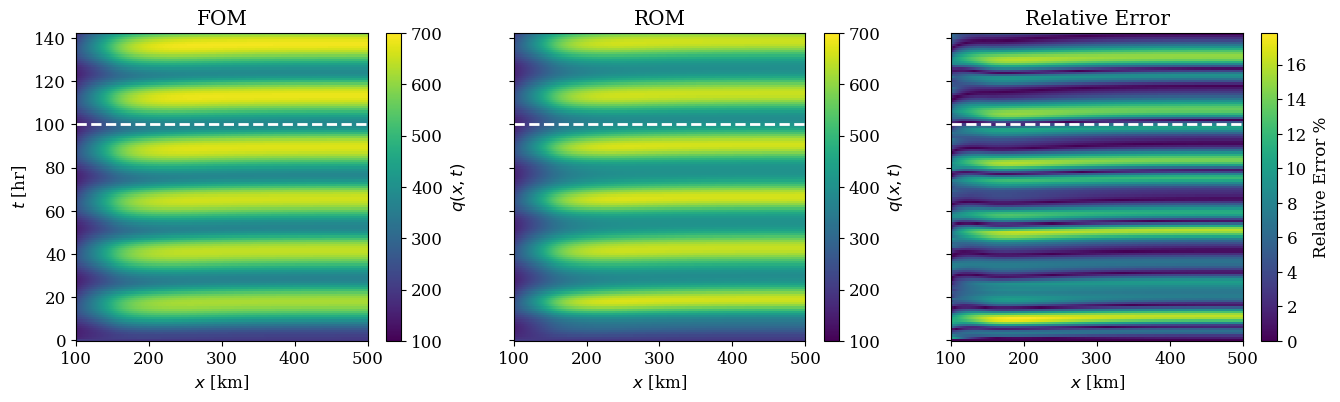

In [27]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(16, 4))
pos = ax[0].pcolormesh(x, time, data.T, vmin=100, vmax=700)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$q(x, t)$', rotation=90)
pos = ax[1].pcolormesh(x, time, Q_ROM.T, vmin=100, vmax=700)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$q(x, t)$', rotation=90)

pos = ax[2].pcolormesh(x, time, 100*np.abs(data.T - Q_ROM.T)/np.abs(data.T))
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r"Relative Error %", rotation=90)

ax[0].axhline(time[100], linewidth=2, color="white", linestyle="--")
ax[1].axhline(time[100], linewidth=2, color="white", linestyle="--")
ax[2].axhline(time[100], linewidth=2, color="white", linestyle="--")
ax[0].set_xlabel("$x$ [km]")
ax[1].set_xlabel("$x$ [km]")
ax[2].set_xlabel("$x$ [km]")
ax[0].set_ylabel("$t$ [hr]")

_ = ax[0].set_title("FOM")
_ = ax[1].set_title("ROM")
_ = ax[2].set_title("Relative Error")